Initial installations if needed

In [1]:
%pip install nltk
%pip install pandas
%pip install numpy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Initial preprocessing - used in HW 0 and 1

In [2]:
# ----- PRE PROCESSING -----
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
import json
import pandas as pd

nltk.download('punkt_tab')
nltk.download('stopwords')

# stemming tool from nltk
stemmer = PorterStemmer()
# a mapping dictionary that help remove punctuations
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)
def get_tokens(text):
  # turn document into lowercase
  lowers = text.lower()
  # remove punctuations
  no_punctuation = lowers.translate(remove_punctuation_map)
  # tokenize document
  tokens = nltk.word_tokenize(no_punctuation)
  # remove stop words
  filtered = [w for w in tokens if not w in stopwords.words('english')]
  # stemming process
  stemmed = []
  for item in filtered:
      stemmed.append(stemmer.stem(item))
  # final unigrams
  return stemmed

traningData = pd.read_csv('24_train_3.csv', header='infer')
# Use HW 0  token filtering step
traningData['Processed_Text'] = traningData['Text'].apply(lambda x: ' '.join(get_tokens(str(x))))
traningData

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\nsano\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nsano\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,ArticleId,Text,Category,Processed_Text
0,1429,sfa awaits report over mikoliunas the scottish...,sport,sfa await report mikoliuna scottish footbal as...
1,1896,parmalat to return to stockmarket parmalat th...,business,parmalat return stockmarket parmalat italian d...
2,1633,edu blasts arsenal arsenal s brazilian midfiel...,sport,edu blast arsen arsen brazilian midfield edu h...
3,2178,henman decides to quit davis cup tim henman ha...,sport,henman decid quit davi cup tim henman retir gr...
4,194,french suitor holds lse meeting european stock...,business,french suitor hold lse meet european stock mar...
...,...,...,...,...
995,1250,blair damaged by blunkett row a majority of ...,politics,blair damag blunkett row major voter 68 believ...
996,1639,a november to remember last saturday one news...,sport,novemb rememb last saturday one newspap procla...
997,916,highbury tunnel players in clear the football ...,sport,highburi tunnel player clear footbal associ sa...
998,2217,top stars join us tsunami tv show brad pitt r...,entertainment,top star join us tsunami tv show brad pitt rob...


Feature extraction methods - 4 methods, TFIDF, CountVectorizer, BERT, GPT

In [3]:
%pip install scikit-learn
%pip install transformers
%pip install torch

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from transformers import BertTokenizer, BertModel
import torch

# ----------- TfidfVectorizer method - convert to number - use TFIDF value -----------
tfidf_vectorizer = TfidfVectorizer() # like hw 1
X_tfidf = tfidf_vectorizer.fit_transform(traningData['Processed_Text'])

In [5]:
# ----------- Bigram Unigram method - cnovert words into matrix of word counts -----------
count_vectorizer = CountVectorizer(ngram_range=(1, 2))  # shape = 1000, 181043 -- 181043 unique words and bigrams for all text
X_count = count_vectorizer.fit_transform(traningData['Processed_Text'])

In [6]:
# ----------- Bert method - convert words into vector -----------
# load bert model and tokenizer
device = torch.device("cpu")
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)

def get_bert_embedding(text):
  # turn text into tokens
  inputs = bert_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
  with torch.no_grad():
    outputs = bert_model(**inputs) # send tokens to get embeddings
  return outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()

X_bert_list = []
for text in traningData['Processed_Text']:
  # get bert embedding for each text
  bert_embedding = get_bert_embedding(text)
  X_bert_list.append(bert_embedding)

X_bert = np.array(X_bert_list)
print(pd.DataFrame(X_bert))


          0         1         2         3         4         5         6    \
0   -0.347496 -0.225865  0.495482 -0.237684  0.241387 -0.199721  0.160331   
1   -0.227841 -0.169153  0.634625 -0.067046  0.577186 -0.130342 -0.216180   
2   -0.282485 -0.095609  0.723575 -0.156782  0.335217 -0.211264 -0.102621   
3   -0.380106 -0.178641  0.622564 -0.139455  0.335117 -0.161952  0.050442   
4   -0.271386 -0.072624  0.566815 -0.136690  0.357096 -0.183400 -0.109878   
..        ...       ...       ...       ...       ...       ...       ...   
995 -0.231768 -0.059449  0.644640 -0.112059  0.192043 -0.153266  0.069223   
996 -0.443378 -0.217632  0.542648 -0.068129  0.254270 -0.175015  0.061309   
997 -0.548414 -0.054915  0.579065 -0.158832  0.335931 -0.251798  0.066812   
998 -0.242989 -0.166043  0.661725 -0.073780  0.289443 -0.102024  0.106976   
999 -0.438576  0.005106  0.537072 -0.126883  0.342277 -0.084894  0.090374   

          7         8         9    ...       758       759       760  \
0  

In [7]:
# ----------- GPT method - convert words into vector -----------
from transformers import GPT2Tokenizer, GPT2Model

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2Model.from_pretrained("gpt2")

tokenizer.pad_token = tokenizer.eos_token

def get_gpt_embedding(text):
  #turn text into tokens
  inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
  with torch.no_grad():
    outputs = model(**inputs) # turn input tokens to vectors
  return outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()

X_gpt_list = []
for text in traningData['Processed_Text']:
  # get gpt embedding for each text
  gpt_embedding = get_gpt_embedding(text)
  X_gpt_list.append(gpt_embedding)

X_gpt = np.array(X_gpt_list)
print(pd.DataFrame(X_gpt))

          0         1         2         3         4         5         6    \
0   -0.328350 -0.059226  0.160945 -0.202329 -0.325820  0.075109 -1.309120   
1    0.067729 -0.300433 -0.239286  0.086089 -0.007095  0.179362 -1.015806   
2   -0.316115 -0.132220 -0.091165 -0.132480 -0.001648  0.239643 -1.553225   
3   -0.081513  0.152388  0.162050 -0.133638 -0.045471  0.160147 -0.883333   
4   -0.001332 -0.011849 -0.311798  0.150192  0.028622  0.363968 -1.043680   
..        ...       ...       ...       ...       ...       ...       ...   
995  0.014867 -0.081154 -0.202077 -0.064668  0.052087  0.114049 -0.817795   
996 -0.117127  0.213099 -0.148555  0.007056 -0.067760  0.060864 -1.935265   
997 -0.210492 -0.142031 -0.058230 -0.118021  0.012026  0.227569 -1.451363   
998 -0.046886  0.065305 -0.044070  0.058977 -0.176519  0.104198 -1.924588   
999 -0.074413  0.213575 -0.009547  0.066872 -0.126054  0.014652 -1.451631   

          7         8         9    ...       758       759       760  \
0  

Train NN on each of the features

In [8]:

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.neural_network import MLPClassifier
import numpy as np

features = {
    "TFIDF": X_tfidf,
    "CountVectorizer": X_count,
    "BERT": X_bert,
    "GPT": X_gpt
}

# initilaize model here
nn_model = MLPClassifier(hidden_layer_sizes=(128, 128), max_iter=500)

# store results here
results = []
for method, X in features.items():
    # 5 fold cross validation
    cross_val = StratifiedKFold(n_splits=5, shuffle=True)

    expectedData = traningData['Category']

    train_accuracies = []
    val_accuracies = []
    # for each split, get train and val accuracies
    for train_index, val_index in cross_val.split(X, expectedData):
        # split
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = expectedData.iloc[train_index], expectedData.iloc[val_index]
        
        # fit
        nn_model.fit(X_train, y_train)
        
        # get accuracies
        train_accuracies.append(nn_model.score(X_train, y_train))
        val_accuracies.append(nn_model.score(X_val, y_val))

    train_mean = np.mean(train_accuracies)
    train_std = np.std(train_accuracies)
    val_mean = np.mean(val_accuracies)
    val_std = np.std(val_accuracies)

    results.append({
        'Feature Method': method,
        'Training Accuracy Mean': train_mean,
        'Training Accuracy Std': train_std,
        'Validation Accuracy Mean': val_mean,
        'Validation Accuracy Std': val_std
    })

results_df = pd.DataFrame(results)
print(results_df)

    Feature Method  Training Accuracy Mean  Training Accuracy Std  \
0            TFIDF                     1.0                    0.0   
1  CountVectorizer                     1.0                    0.0   
2             BERT                     1.0                    0.0   
3              GPT                     1.0                    0.0   

   Validation Accuracy Mean  Validation Accuracy Std  
0                     0.975                 0.014491  
1                     0.933                 0.012884  
2                     0.965                 0.014832  
3                     0.958                 0.009274  


In [ ]:
# smaller version

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.neural_network import MLPClassifier
import numpy as np

features = {
    "TFIDF": X_tfidf,
    "CountVectorizer": X_count,
    "BERT": X_bert,
    "GPT": X_gpt
}

# initilaize model here
nn_model = MLPClassifier(hidden_layer_sizes=(32, 32), max_iter=500)

# store results here
results = []
for method, X in features.items():
    # 5 fold cross validation
    cross_val = StratifiedKFold(n_splits=5, shuffle=True)

    expectedData = traningData['Category']

    train_accuracies = []
    val_accuracies = []
    # for each split, get train and val accuracies
    for train_index, val_index in cross_val.split(X, expectedData):
        # split
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = expectedData.iloc[train_index], expectedData.iloc[val_index]
        
        # fit
        nn_model.fit(X_train, y_train)
        
        # get accuracies
        train_accuracies.append(nn_model.score(X_train, y_train))
        val_accuracies.append(nn_model.score(X_val, y_val))

    train_mean = np.mean(train_accuracies)
    train_std = np.std(train_accuracies)
    val_mean = np.mean(val_accuracies)
    val_std = np.std(val_accuracies)

    results.append({
        'Feature Method': method,
        'Training Accuracy Mean': train_mean,
        'Training Accuracy Std': train_std,
        'Validation Accuracy Mean': val_mean,
        'Validation Accuracy Std': val_std
    })

results_df = pd.DataFrame(results)
print(results_df)

c:\Users\nsano\source\repos\CSE572HW2\cse572\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


    Feature Method  Training Accuracy Mean  Training Accuracy Std  \
0            TFIDF                     1.0                    0.0   
1  CountVectorizer                     1.0                    0.0   
2             BERT                     1.0                    0.0   
3              GPT                     1.0                    0.0   

   Validation Accuracy Mean  Validation Accuracy Std  
0                     0.972                 0.012083  
1                     0.935                 0.020736  
2                     0.964                 0.013191  
3                     0.962                 0.009798  


Plot results

In [ ]:
%pip install matplotlib

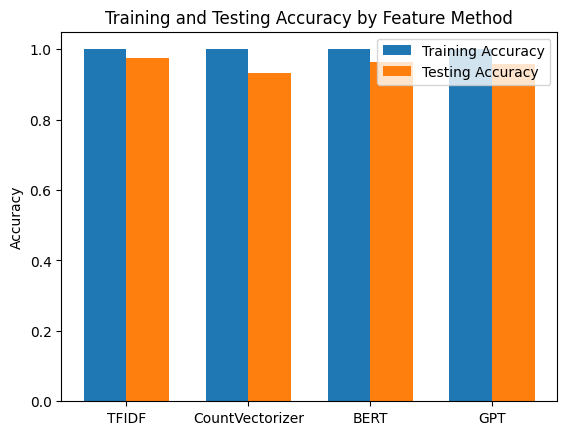

In [ ]:
import matplotlib.pyplot as plt

# Prepare data for plotting
methods = results_df["Feature Method"]
training_accuracies = results_df["Training Accuracy Mean"]
validation_accuracies = results_df["Validation Accuracy Mean"]

# Plotting
x = np.arange(len(methods))
width = 0.35  # Bar width

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, training_accuracies, width, label='Training Accuracy')
rects2 = ax.bar(x + width/2, validation_accuracies, width, label='Testing Accuracy')

ax.set_ylabel('Accuracy')
ax.set_title('Training and Testing Accuracy by Feature Method')
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.legend()

plt.show()


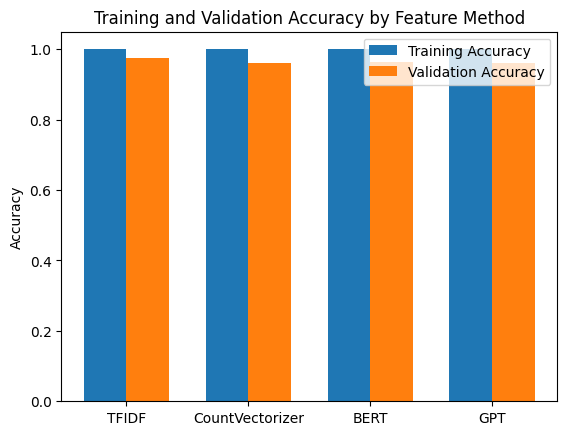

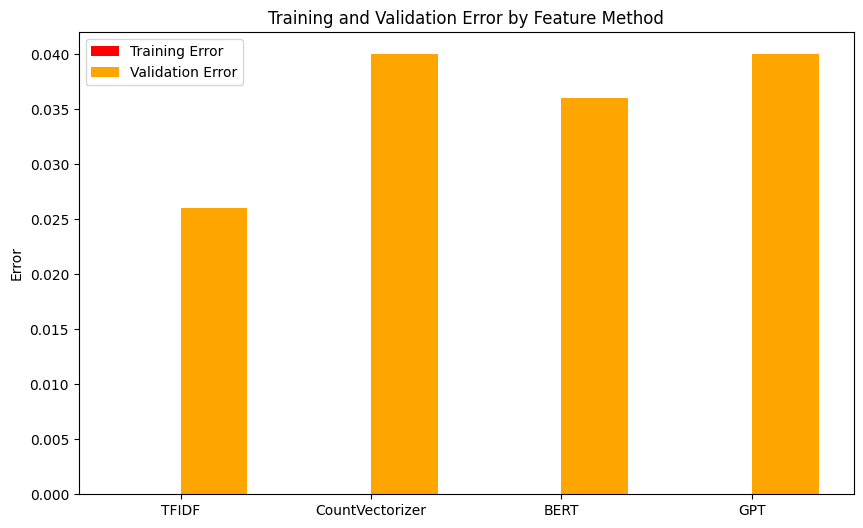

In [14]:
# plotting smaller version
import matplotlib.pyplot as plt

# Prepare data for plotting
methods = results_df["Feature Method"]
training_accuracies = results_df["Training Accuracy Mean"]
validation_accuracies = results_df["Validation Accuracy Mean"]
training_errors = 1 - training_accuracies
validation_errors = 1 - validation_accuracies

# Plotting accuracy
x = np.arange(len(methods))
width = 0.35  # Bar width

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, training_accuracies, width, label='Training Accuracy')
rects2 = ax.bar(x + width/2, validation_accuracies, width, label='Validation Accuracy')

ax.set_ylabel('Accuracy')
ax.set_title('Training and Validation Accuracy by Feature Method')
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.legend()

# Plotting error
fig, ax2 = plt.subplots(figsize=(10, 6))
rects3 = ax2.bar(x - width/2, training_errors, width, label='Training Error', color='red')
rects4 = ax2.bar(x + width/2, validation_errors, width, label='Validation Error', color='orange')

ax2.set_ylabel('Error')
ax2.set_title('Training and Validation Error by Feature Method')
ax2.set_xticks(x)
ax2.set_xticklabels(methods)
ax2.legend()

plt.show()